In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [3]:
# --- Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# --- Download data (be explicit about auto_adjust)
data = yf.download("AAPL", start="2015-01-01", end="2021-12-31", auto_adjust=True)
data = data[['Close']].dropna()

[*********************100%***********************]  1 of 1 completed


In [5]:
# --- Train/test split BEFORE scaling (chronological split)
train_ratio = 0.8
split_idx = int(len(data) * train_ratio)
train_df = data.iloc[:split_idx]
test_df  = data.iloc[split_idx:]

In [6]:
# --- Scale with train-only fit to avoid leakage
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled  = scaler.transform(test_df)

def create_dataset(arr, time_step=60):
    X, y = [], []
    for i in range(len(arr) - time_step):
        X.append(arr[i:i+time_step, 0])
        y.append(arr[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)
X_test,  y_test  = create_dataset(test_scaled,  time_step)

In [7]:
# --- LSTM expects 3D [samples, timesteps, features]
X_train = X_train.reshape(-1, time_step, 1)
X_test  = X_test.reshape(-1, time_step, 1)

In [8]:
# --- Model
model = Sequential([
    Input(shape=(time_step, 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0059
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0016
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0016
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0013
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0014
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0010
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0014
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0012
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 9.3979e-04
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 8.7332e-04


In [9]:
# --- Predict
y_pred_scaled = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


In [10]:
# --- Invert scale both y_test and y_pred
y_pred = scaler.inverse_transform(y_pred_scaled)
# y_test is 1D; make it 2D to inverse_transform, then ravel back
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

In [11]:
# --- Metrics
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred.ravel()))
mae  = mean_absolute_error(y_test_inv, y_pred.ravel())
print(f"RMSE: {rmse:,.4f}  |  MAE: {mae:,.4f}")

RMSE: 5.1696  |  MAE: 4.2124


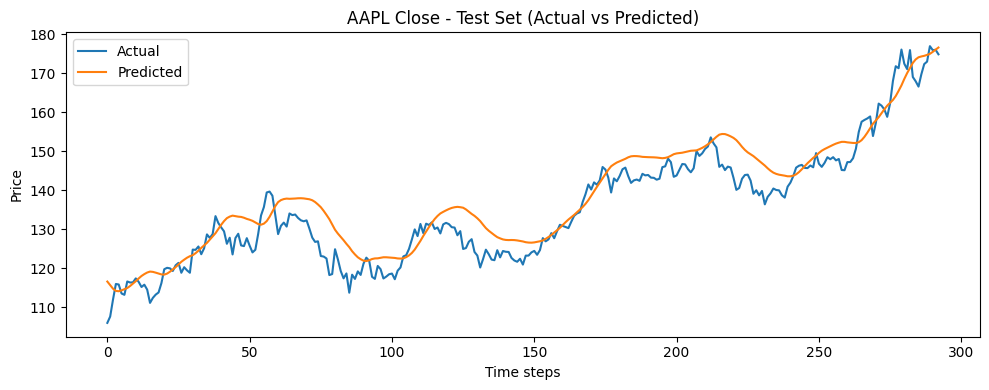

In [12]:
# --- Plot Actual vs Predicted (aligned to test window)
plt.figure(figsize=(10,4))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("AAPL Close - Test Set (Actual vs Predicted)")
plt.xlabel("Time steps")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# --- Optional: one-step-ahead forecasting on the test tail
last_window = test_scaled[-time_step:].reshape(1, time_step, 1)
next_scaled = model.predict(last_window)
next_price  = scaler.inverse_transform(next_scaled)[0,0]
print("Next one-step prediction (relative to last test point):", round(next_price, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Next one-step prediction (relative to last test point): 177.12
